<a href="https://colab.research.google.com/github/fambargh/SAMPLE/blob/master/comparedatasetinsegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir


  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-rpkmm0if
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-rpkmm0if
     |████████████████████████████████| 634kB 42.4MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.4-cp36-none-any.whl size=61995 sha256=b88f8d71030119f43d97a2114fc61d6269e536fea23838abfdc81c09a86c173e
  Stored in directory: /tmp/pip-ephem-wheel-cache-g_oh2glx/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=f762e26524a901e51789bae7e0e24182cc541d973687a94c33c8b6983a266759
  Stored in directory: /tmp/pip-ephem-wheel-cache-g_oh2glx/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albu

In [2]:
# Install required libs
!pip install -U --pre segmentation-models --user

In [3]:
from zipfile import ZipFile
filename = "man1.zip"

with ZipFile(filename,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [4]:
from zipfile import ZipFile
filename = "mannn.zip"

with ZipFile(filename,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [6]:
import os
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
x_train_dir = '/content/man1/'
y_train_dir = '/content/mannn/'

In [0]:
x_train_dir = '/content/image_train/'
y_train_dir = '/content/annotate_cup_train/'

x_valid_dir = '/content/image_valid/'
y_valid_dir = '/content/annotate_cup_valid'

x_test_dir = '/content/image_test/'
y_test_dir = '/content/annotate_cup_test/'

In [0]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['0', 'sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

In [40]:
DATA_DIR = './data/CamVid/'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print('Done!')

Loading data...
Done!


In [58]:
import os
from collections import OrderedDict

import albumentations as A
import cv2
import numpy as np
import torch
import torch.nn as nn
#from catalyst.dl.callbacks import Callback, RunnerState
#from catalyst.dl.experiments import SupervisedRunner
from pytorch_toolbelt.utils import fs
from pytorch_toolbelt.utils.catalyst_utils import ShowPolarBatchesCallback
from pytorch_toolbelt.utils.fs import id_from_fname
from pytorch_toolbelt.utils.torch_utils import tensor_from_rgb_image, to_numpy, \
    rgb_image_from_tensor
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from models.fpn import effnetB7_fpn
from models.linknet import LinkNet152

CLASSES = ['sky', 'building', 'pole', 'road', 'pavement',
           'tree', 'signsymbol', 'fence', 'car',
           'pedestrian', 'bicyclist', 'unlabelled']

COLORS = [(128, 128, 128), (128, 0, 0), (192, 192, 128), (128, 64, 128),
          (0, 0, 192),
          (128, 128, 0), (192, 128, 128), (64, 64, 128), (64, 0, 128),
          (64, 64, 0), (0, 128, 192), (0, 0, 0)]


class CamVidDataset(Dataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline
            (e.g. flip, scale, etc.)
    """

    def __init__(
            self,
            images_dir,
            masks_dir,
            transform=A.Normalize()
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in
                           self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in
                          self.ids]
        self.transform = transform

    def __getitem__(self, i):
        # read data
        image = fs.read_rgb_image(self.images_fps[i])
        mask = fs.read_image_as_is(self.masks_fps[i])
        assert mask.max() < len(CLASSES)

        # apply augmentations
        sample = self.transform(image=image, mask=mask)
        image, mask = sample['image'], sample['mask']

        return {
            "image_id": id_from_fname(self.images_fps[i]),
            "features": tensor_from_rgb_image(image),
            "targets": torch.from_numpy(mask).long()
        }

    def __len__(self):
        return len(self.ids)


def get_training_augmentation():
    train_transform = [
        A.RandomSizedCrop(min_max_height=(300, 360), height=320, width=320,
                          always_apply=True),
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.CLAHE(),
            A.RandomBrightnessContrast(),
            A.RandomGamma(),
            A.HueSaturationValue(),
            A.NoOp()
        ]),
        A.OneOf([
            A.IAAAdditiveGaussianNoise(p=0.2),
            A.IAASharpen(),
            A.Blur(blur_limit=3),
            A.MotionBlur(blur_limit=3),
            A.NoOp()
        ]),
        A.OneOf([
            A.RandomFog(),
            A.RandomSunFlare(),
            A.RandomRain(),
            A.RandomSnow(),
            A.NoOp()
        ]),
        A.Normalize(),
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [
        A.Normalize(),
    ]
    return A.Compose(test_transform)


def visualize_predictions(input: dict, output: dict,
                          mean=(0.485, 0.456, 0.406),
                          std=(0.229, 0.224, 0.225)):
    images = []
    for image, target, image_id, logits in zip(input['features'],
                                               input['targets'],
                                               input['image_id'],
                                               output['logits']):
        image = rgb_image_from_tensor(image, mean, std)
        # target = to_numpy(target).squeeze(0)
        logits = to_numpy(logits).argmax(axis=0)

        overlay = image.copy()
        for class_index, class_color in enumerate(COLORS):
            image[logits == class_index, :] = class_color

        overlay = cv2.addWeighted(image, 0.5, overlay, 0.5, 0, dtype=cv2.CV_8U)
        cv2.putText(overlay, str(image_id), (10, 15), cv2.FONT_HERSHEY_PLAIN, 1, (250, 250, 250))

        images.append(overlay)
    return images



def main():
    DATA_DIR = os.path.join(os.path.dirname(__file__), 'CamVid')

    x_train_dir = os.path.join(DATA_DIR, 'train')
    y_train_dir = os.path.join(DATA_DIR, 'trainannot')

    x_valid_dir = os.path.join(DATA_DIR, 'val')
    y_valid_dir = os.path.join(DATA_DIR, 'valannot')

    x_test_dir = os.path.join(DATA_DIR, 'test')
    y_test_dir = os.path.join(DATA_DIR, 'testannot')

    train_ds = CamVidDataset(x_train_dir, y_train_dir,
                             transform=get_training_augmentation())
    valid_ds = CamVidDataset(x_valid_dir, y_valid_dir,
                             transform=get_validation_augmentation())
    test_ds = CamVidDataset(x_test_dir, y_test_dir,
                            transform=get_validation_augmentation())

    data_loaders = OrderedDict()
    num_train_samples = len(train_ds)
    mul_factor = 10
    batch_size = 4 * torch.cuda.device_count()
    data_loaders['train'] = DataLoader(train_ds,
                                       batch_size=batch_size,
                                       shuffle=False,
                                       num_workers=8,
                                       pin_memory=True,
                                       sampler=WeightedRandomSampler(np.ones(num_train_samples),
                                                                     num_train_samples * mul_factor))

    data_loaders['valid'] = DataLoader(valid_ds,
                                       batch_size=batch_size,
                                       shuffle=False,
                                       num_workers=0,
                                       pin_memory=True)

    data_loaders['test'] = DataLoader(test_ds,
                                      batch_size=batch_size,
                                      shuffle=False,
                                      num_workers=0,
                                      pin_memory=True)

    print(len(train_ds), len(valid_ds))

    num_classes = len(CLASSES)
    model = effnetB7_fpn(num_classes).cuda()

    # model runner
    runner = SupervisedRunner()

    optimizer = Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                     milestones=[50, 75, 100, 125, 130, 135, 140, 145],
                                                     gamma=0.5)

    # model training
    runner.train(
        model=model,
        criterion=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        scheduler=scheduler,
        callbacks=[
            MulticlassIoUCallback(prefix='iou'),
            ShowPolarBatchesCallback(visualize_predictions, metric='iou', minimize=True),
        ],
        logdir='runs/effnetB7_fpn',
        loaders=data_loaders,
        num_epochs=150,
        verbose=True,
        main_metric='iou',
        minimize_metric=False
    )


if __name__ == '__main__':
    main()

ModuleNotFoundError: ignored

In [0]:
DATA_DIR = './data/CamVid/'
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

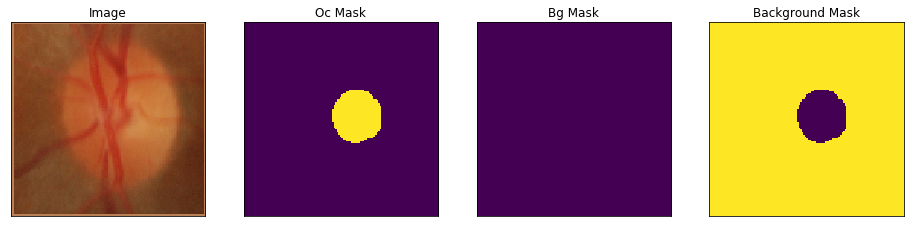

In [8]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['0', 'unlabelled'])

image, mask = dataset[8] # get some sample
visualize(
    image=image, 
    OC_mask=mask[..., 0].squeeze(),
    bg_mask=mask[..., 1].squeeze(),
    background_mask=mask[..., 2].squeeze(),
)


In [0]:
import albumentations as A


In [0]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=128, min_width=128, always_apply=True, border_mode=0),
        A.RandomCrop(height=128, width=128, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 128"""
    test_transform = [
        A.PadIfNeeded(128, 128)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

/usr/local/lib/python3.6/dist-packages/albumentations/augmentations/transforms.py:2910: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  "Using lambda is incompatible with multiprocessing. "


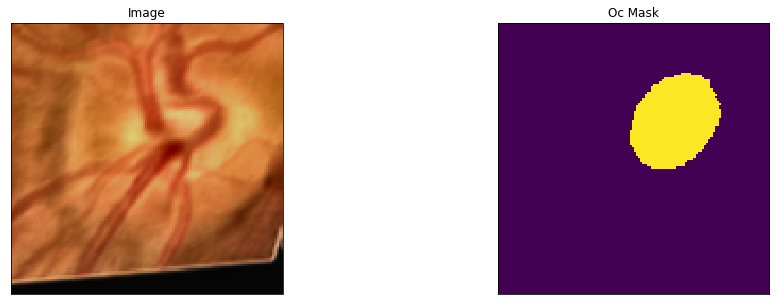

In [11]:
# Lets look at augmented data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['0', 'unlabelled'], augmentation=get_training_augmentation())

image, mask = dataset[12] # get some sample
visualize(
    image=image, 
    OC_mask=mask[..., 0].squeeze(),
    #background_mask=mask[..., 2].squeeze(),
)

In [11]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [0]:
BACKBONE = 'seresnet50'
BATCH_SIZE =32
CLASSES = ['0', 'unlabelled']
#LR = 0.01
#EPOCHS = 2
preprocess_input = sm.get_preprocessing(BACKBONE)

In [0]:
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

In [17]:
n_classes

3

In [0]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

In [25]:
print(n_classes)

1


In [12]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
#train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 128, 128, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 128, 128, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

/usr/local/lib/python3.6/dist-packages/albumentations/augmentations/transforms.py:2910: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  "Using lambda is incompatible with multiprocessing. "


In [0]:
# define optomizer
opt = SGD()

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(opt, total_loss, metrics)

In [26]:
history = model.fit_generator(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=30, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/30
5/5 [==============================] - 19s 4s/step - loss: 1.5088 - iou_score: 0.5824 - f1-score: 0.7341 - val_loss: 1.3081 - val_iou_score: 0.6757 - val_f1-score: 0.7917
Epoch 2/30
5/5 [==============================] - 4s 864ms/step - loss: 1.3217 - iou_score: 0.6773 - f1-score: 0.8074 - val_loss: 1.1343 - val_iou_score: 0.7754 - val_f1-score: 0.8658
Epoch 3/30
5/5 [==============================] - 4s 870ms/step - loss: 1.1850 - iou_score: 0.7178 - f1-score: 0.8354 - val_loss: 1.0714 - val_iou_score: 0.7858 - val_f1-score: 0.8731
Epoch 4/30
5/5 [==============================] - 4s 863ms/step - loss: 1.0664 - iou_score: 0.7370 - f1-score: 0.8483 - val_loss: 1.0499 - val_iou_score: 0.7852 - val_f1-score: 0.8721
Epoch 5/30
5/5 [==============================] - 4s 865ms/step - loss: 1.0308 - iou_score: 0.7458 - f1-score: 0.8539 - val_loss: 0.9694 - val_iou_score: 0.7957 - val_f1-score: 0.8785
Epoch 6/30
5/5 [==============================] - 4s 863ms/step - loss: 0.9052 - i

Epoch 1/40
5/5 [==============================] - 23s 5s/step - loss: 1.6075 - iou_score: 0.5055 - f1-score: 0.6697 - val_loss: 1.2719 - val_iou_score: 0.7291 - val_f1-score: 0.8323
Epoch 2/40
5/5 [==============================] - 4s 884ms/step - loss: 1.3832 - iou_score: 0.6425 - f1-score: 0.7816 - val_loss: 1.1246 - val_iou_score: 0.7901 - val_f1-score: 0.8757
Epoch 3/40
5/5 [==============================] - 4s 854ms/step - loss: 1.2425 - iou_score: 0.6958 - f1-score: 0.8203 - val_loss: 1.0268 - val_iou_score: 0.8123 - val_f1-score: 0.8911
Epoch 4/40
5/5 [==============================] - 4s 855ms/step - loss: 1.2085 - iou_score: 0.6873 - f1-score: 0.8145 - val_loss: 1.0400 - val_iou_score: 0.7788 - val_f1-score: 0.8683
Epoch 5/40
5/5 [==============================] - 4s 865ms/step - loss: 1.0979 - iou_score: 0.7219 - f1-score: 0.8382 - val_loss: 1.0019 - val_iou_score: 0.7770 - val_f1-score: 0.8674
Epoch 6/40
5/5 [==============================] - 4s 866ms/step - loss: 0.9556 - i

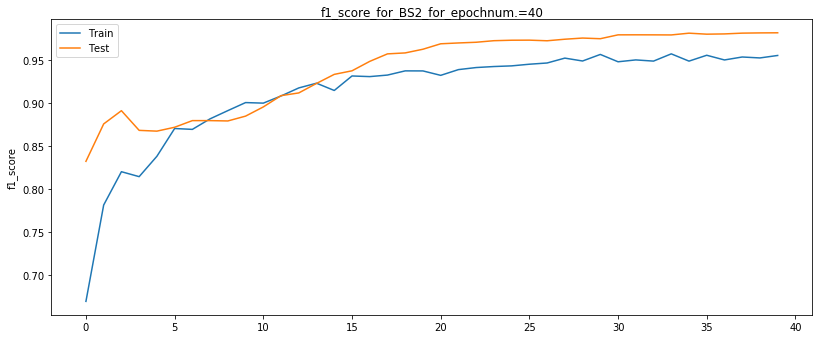

In [14]:
# study of eppoch number on metrics for segmentation problem
from keras.optimizers import SGD
from matplotlib import pyplot


# fit a model and plot learning curve
def fit_model(train_data, validimage,EPOCHS):
  # define network parameters
  n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
  activation = 'sigmoid' if n_classes == 1 else 'softmax'
  # define model
  model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)
  opt = SGD()
  dice_loss = sm.losses.DiceLoss()
  focal_loss = sm.losses.BinaryFocalLoss() 
  total_loss = dice_loss + (1 * focal_loss)
  metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
  model.compile(opt, total_loss, metrics)
  # fit model
  history = model.fit_generator(train_dataloader, 
                                steps_per_epoch=len(train_data), 
                                epochs=EPOCHS, 
                                callbacks=callbacks, 
                                validation_data=validimage, 
                                validation_steps=len(validimage),
                                )
  # plot learning curves
  pyplot.plot(history.history['f1-score'], label='train')
  pyplot.plot(history.history['val_f1-score'], label='test')
  pyplot.title('f1_score_for_BS2_for_epochnum.='+str(EPOCHS), pad=-50)
  plt.ylabel('f1_score')
  plt.legend(['Train', 'Test'], loc='upper left')

# create learning curves for different epoch numbers
EPOCHS = [40]
#EPOCHS = [10,20,30,40,60,80,100]
for i in range(len(EPOCHS)):
  plt.figure(figsize=(30, 25))
  # determine the plot number
  plot_no = 420 + (i+1)
  pyplot.subplot(plot_no)
  # fit model and plot learning curves for an epoch number
  fit_model(train_dataloader, valid_dataloader, EPOCHS[i])
# show learning curves
pyplot.show()

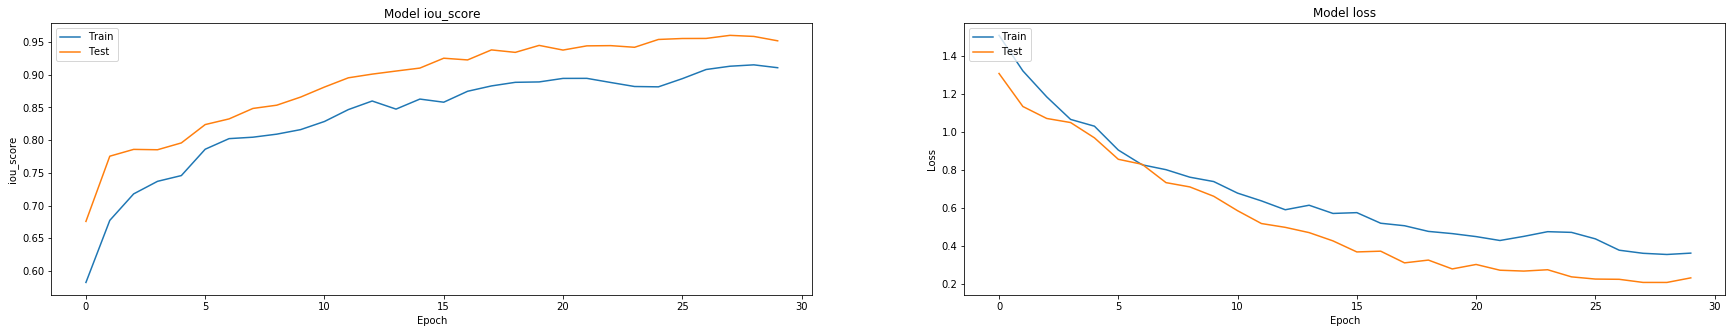

In [27]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [28]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

/usr/local/lib/python3.6/dist-packages/albumentations/augmentations/transforms.py:2910: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  "Using lambda is incompatible with multiprocessing. "


In [0]:
# load best weights
model.load_weights('best_model.h5')


In [30]:
scores = model.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

Loss: 0.27235
mean iou_score: 0.94694
mean f1-score: 0.97165


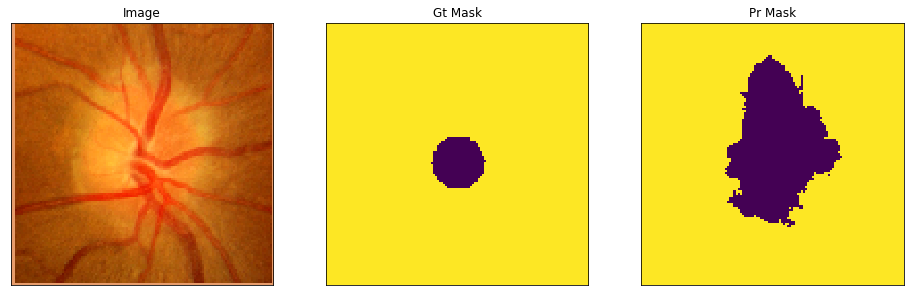

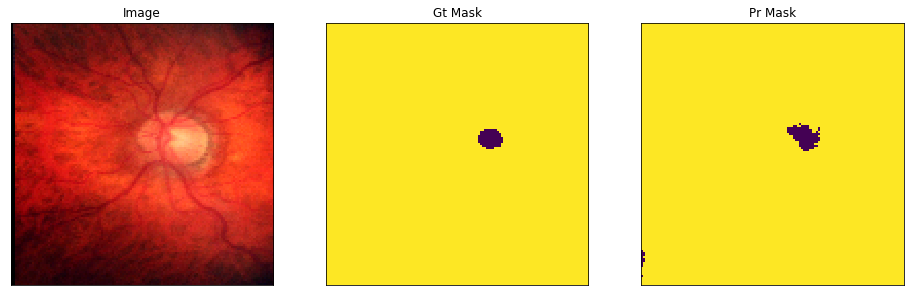

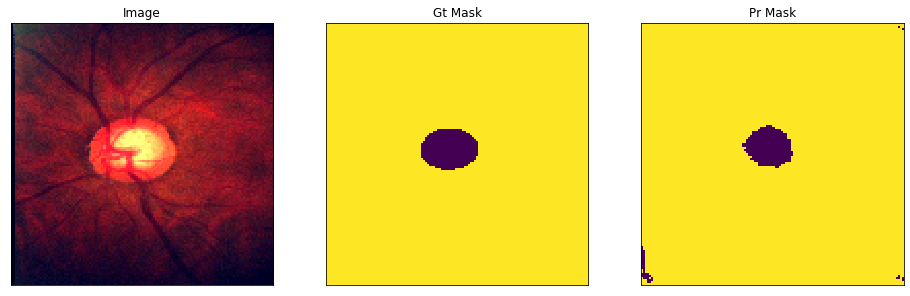

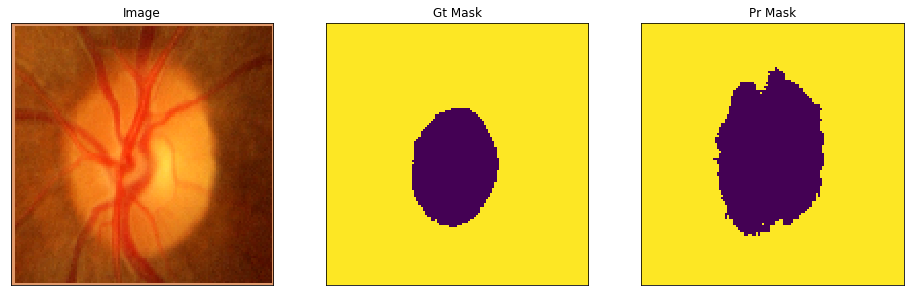

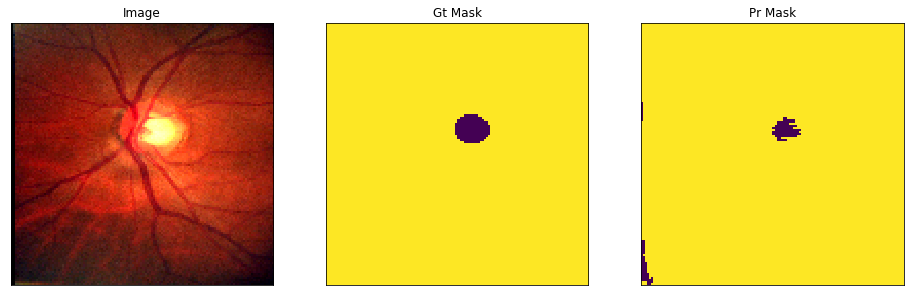

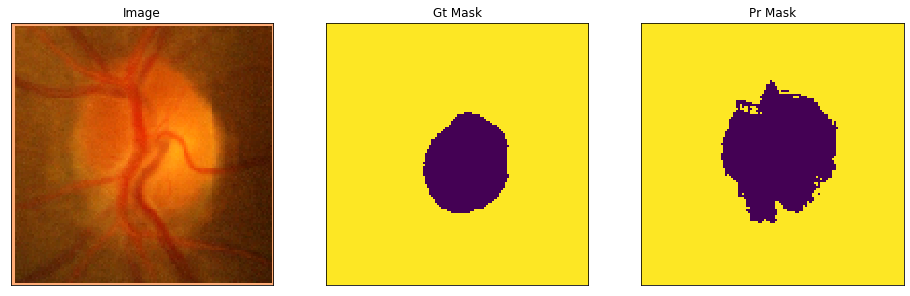

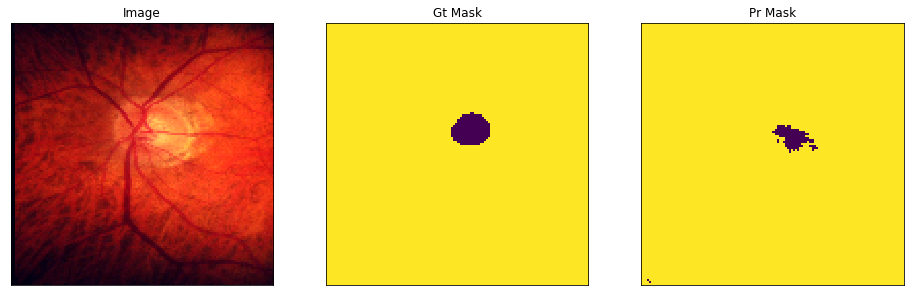

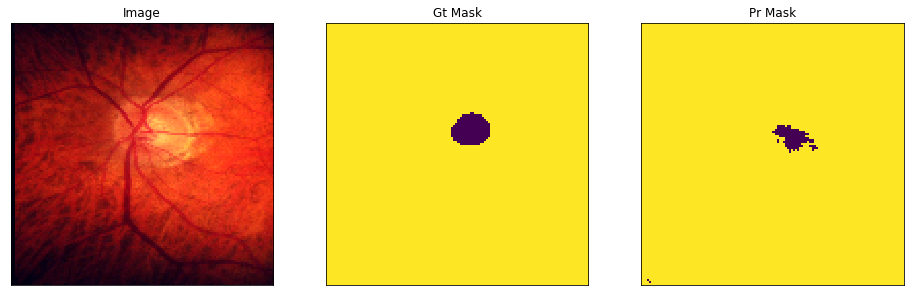

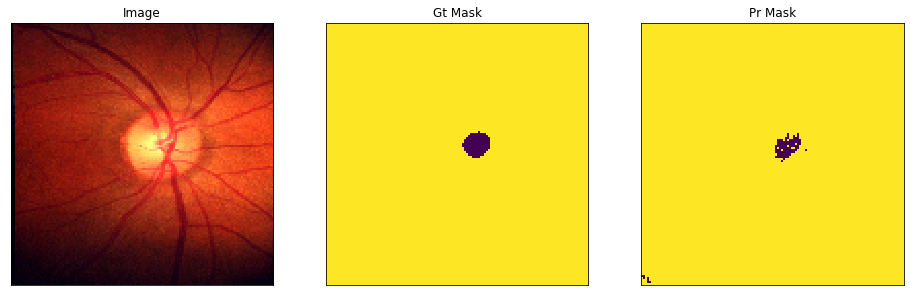

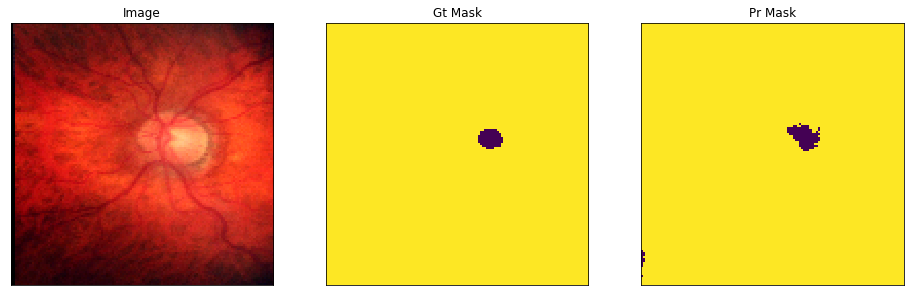

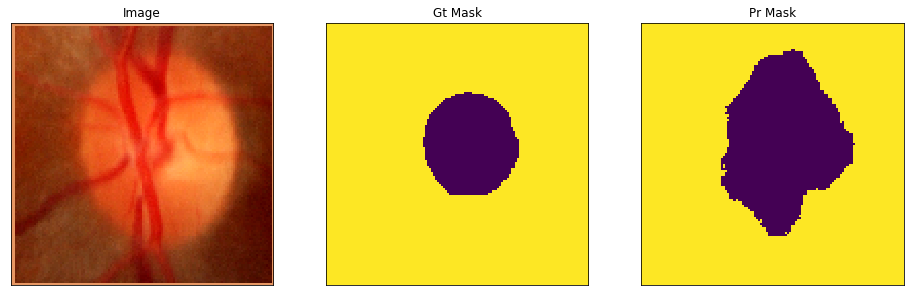

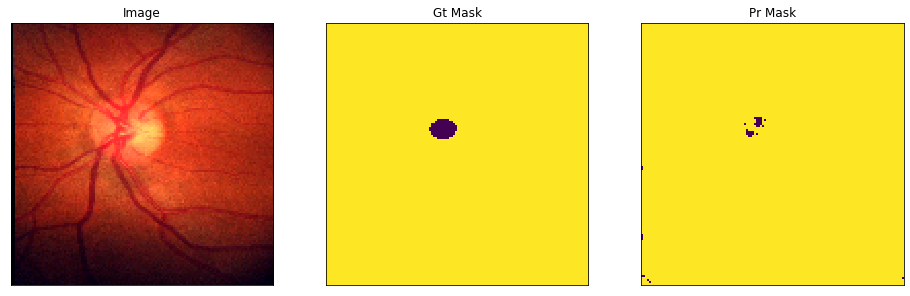

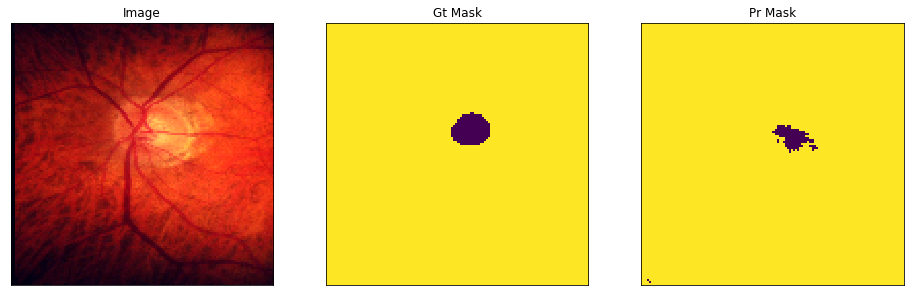

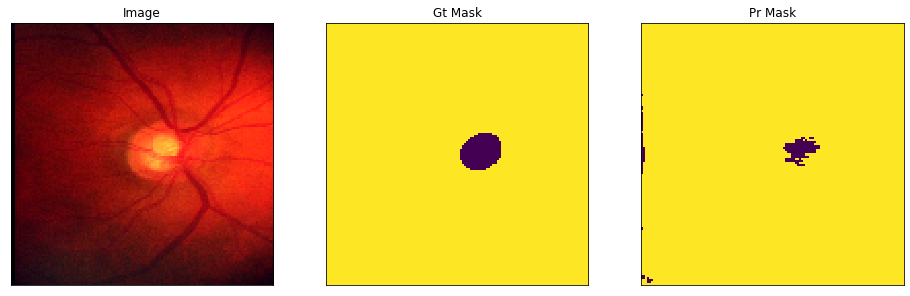

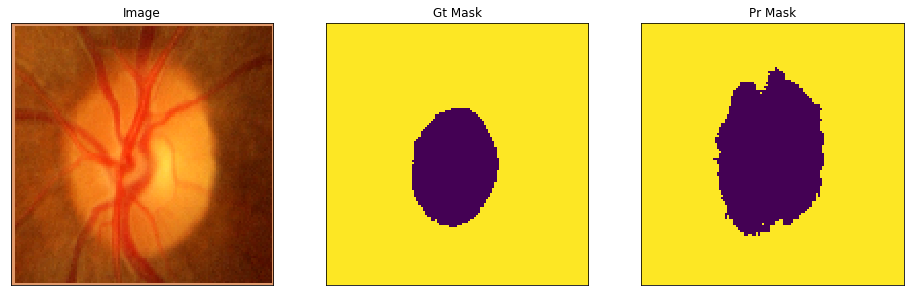

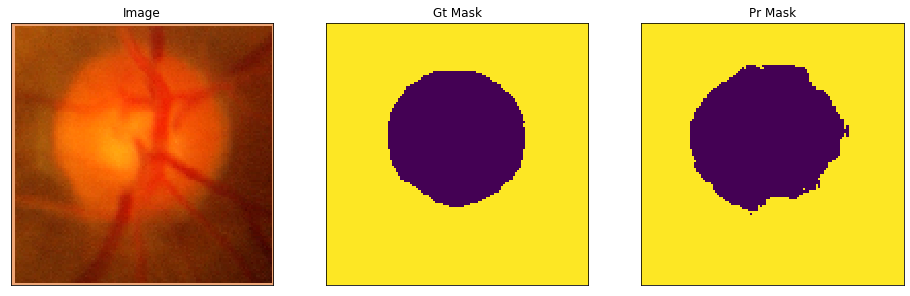

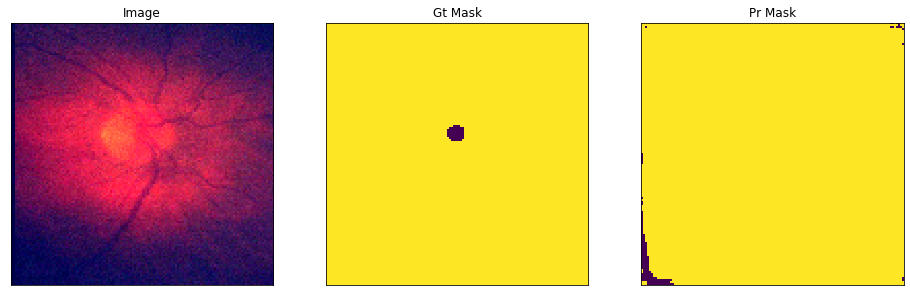

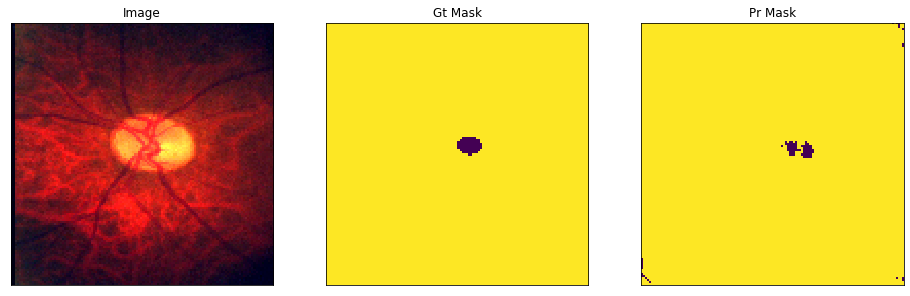

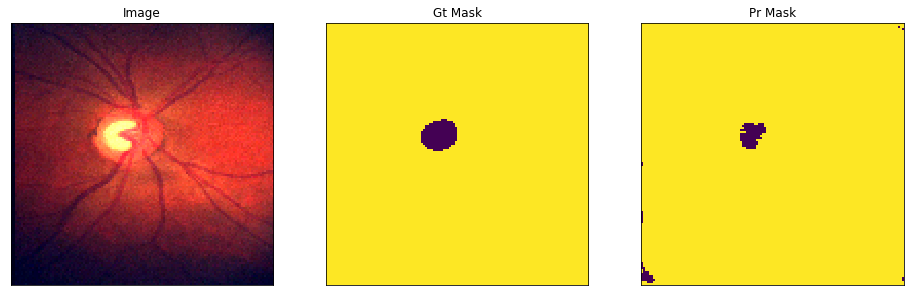

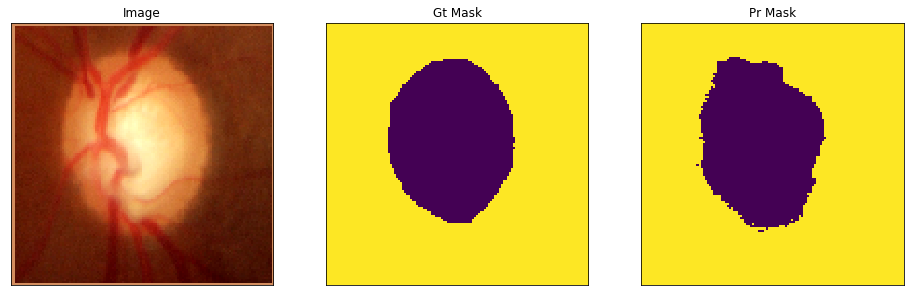

In [31]:
n = 20
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )